In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os, sys, random, itertools, codecs
import json
import re
import tarfile
import tempfile
import keras
import numpy as np
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import merge, recurrent, Dense, Input, Dropout, TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from keras.utils import np_utils

In [ ]:
def extract_tokens_from_binary_parse(parse):
    return parse.replace('(', ' ').replace(')', ' ').replace('-LRB-', '(').replace('-RRB-', ')').split()

def yield_examples(fn, skip_no_majority=True, limit=None):
      for i, line in enumerate(codecs.open(fn, encoding='utf-8')):#open(fn)):
        if limit and i > limit: break
        data = json.loads(line)
        label = data['gold_label']
        s1 = ' '.join(extract_tokens_from_binary_parse(data['sentence1_binary_parse']))
        s2 = ' '.join(extract_tokens_from_binary_parse(data['sentence2_binary_parse']))
        if skip_no_majority and label == '-': continue
        yield (label, s1, s2)

def get_data(fn, limit=None):
    fn = os.path.join('snli/snli_1.0',fn)
    raw_data = list(yield_examples(fn=fn, limit=limit))
    left = [s1 for _, s1, s2 in raw_data]
    right = [s2 for _, s1, s2 in raw_data]
    print(max(len(x.split()) for x in left))
    print(max(len(x.split()) for x in right))

    LABELS = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
    Y = np.array([LABELS[l] for l, s1, s2 in raw_data])
    Y = np_utils.to_categorical(Y, len(LABELS))

    return left, right, Y

In [ ]:
training = get_data('/content/drive/MyDrive/snli_1.0/snli_1.0_train.jsonl')

validation = get_data('/content/drive/MyDrive/snli_1.0/snli_1.0_dev.jsonl')

test = get_data('/content/drive/MyDrive/snli_1.0/snli_1.0_test.jsonl')


82
62
59
55
57
30


In [ ]:
tokenizer = Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(training[0] + training[1])
VOCAB = len(tokenizer.word_counts) + 1
LABELS = {'contradiction': 0, 'neutral': 1, 'entailment': 2}

RNN = recurrent.LSTM
LAYERS = 1
USE_GLOVE = True
TRAIN_EMBED = False
EMBED_HIDDEN_SIZE = 300
SENT_HIDDEN_SIZE = 300
BATCH_SIZE = 1000
PATIENCE = 4 # 8
MAX_EPOCHS = 10
MAX_LEN = 42
DP = 0.2
L2 = 4e-6
ACTIVATION = 'relu'
OPTIMIZER = 'rmsprop'

In [ ]:
to_seq = lambda X: pad_sequences(tokenizer.texts_to_sequences(X), maxlen=MAX_LEN)
prepare_data = lambda data: (to_seq(data[0][:25000]), to_seq(data[1][:25000]), data[2][:25000])

training = prepare_data(training)
validation = prepare_data(validation)
test = prepare_data(test)
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import merge, recurrent, Dense, Input, Dropout, TimeDistributed, concatenate
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from keras.layers.recurrent import LSTM
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
import numpy as np
# Parameters
MAX_SEQ_LEN = 42
LSTM_UNITS = 64

VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
EMBED_HIDDEN_SIZE = 100
SENT_HIDDEN_SIZE = 100
TRAIN_EMBED = False

L2 = 4e-6
ACTIVATION = 'relu'
DROPOUT = 0.2
LEARNING_RATE = 0.01
RHO = 0.9
EPSILON = 1e-08
DECAY = 0.0

CATEGORIES = 3
BATCH_SIZE = 512
TRAINING_EPOCHS = 50
VALIDATION_SPLIT = 0.02

PATIENCE = 4

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten

GLOVE_STORE = 'precomputed_glove.weights'
if USE_GLOVE:
    if not os.path.exists(GLOVE_STORE + '.npy'):
        print('Computing GloVe')

        embeddings_index = {}
        with open(os.path.join('/content/drive/MyDrive/glove/glove.6B.100d.txt')) as f:
            for line in f:
                values = line.split(' ')
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs

        # prepare embedding matrix
        embedding_matrix = np.zeros((VOCAB, EMBED_HIDDEN_SIZE))
        for word, i in tokenizer.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
            else:
                print('Missing from GloVe: {}'.format(word))
  
        np.save(GLOVE_STORE, embedding_matrix)

    print('Loading GloVe')
    embedding_matrix = np.load(GLOVE_STORE + '.npy')

    print('Total number of null word embeddings:')
    print(np.sum(np.sum(embedding_matrix, axis=1) == 0))

    embed = Embedding(VOCAB, EMBED_HIDDEN_SIZE, weights=[embedding_matrix], input_length=MAX_LEN, trainable=TRAIN_EMBED)

# Define the input layers and its shapes for premise and hypothesis
premise = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
hypothesis = Input(shape=(MAX_SEQ_LEN,), dtype='int32')

# Embed the premise and hypothesis
premise_embedded = embed(premise)
hypothesis_embedded = embed(hypothesis)

premise_BiLSTM = LSTM(LSTM_UNITS, return_sequences=True)(premise_embedded)
layer0 = LSTM(LSTM_UNITS)(premise_BiLSTM)
premise_BiLSTM = Dropout(DROPOUT)(layer0)
hypothesis_BiLSTM = LSTM(LSTM_UNITS, return_sequences=True)(hypothesis_embedded)
layer01 = LSTM(LSTM_UNITS)(hypothesis_BiLSTM)
hypothesis_BiLSTM = Dropout(DROPOUT)(layer01)
# print(premise_BiLSTM)
# batch normalization
premise_normalized = BatchNormalization()(premise_BiLSTM)
hypothesis_normalized = BatchNormalization()(hypothesis_BiLSTM)
# print(premise_normalized.shape)
train_input = concatenate([premise_normalized, hypothesis_normalized])
train_input = Dropout(DROPOUT)(train_input)
# train_input = embed(train_input)
# print(train_input.shape)
# layer0 = LSTM(LSTM_UNITS)(train_input)
layer1 = Dense(2 * SENT_HIDDEN_SIZE, activation=ACTIVATION, kernel_regularizer=l2(L2))(train_input)
layer2 = Dropout(DROPOUT)(layer1)
layer3 = Dense(SENT_HIDDEN_SIZE, activation=ACTIVATION)(layer2)
layer4 = BatchNormalization()(layer3)

prediction = Dense(CATEGORIES, activation='softmax')(layer4)


model = Model(inputs=[premise, hypothesis], outputs=prediction)

# # Compile the model and print out the model summary
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Loading GloVe
Total number of null word embeddings:
16475
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 100)      4239100     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (Non

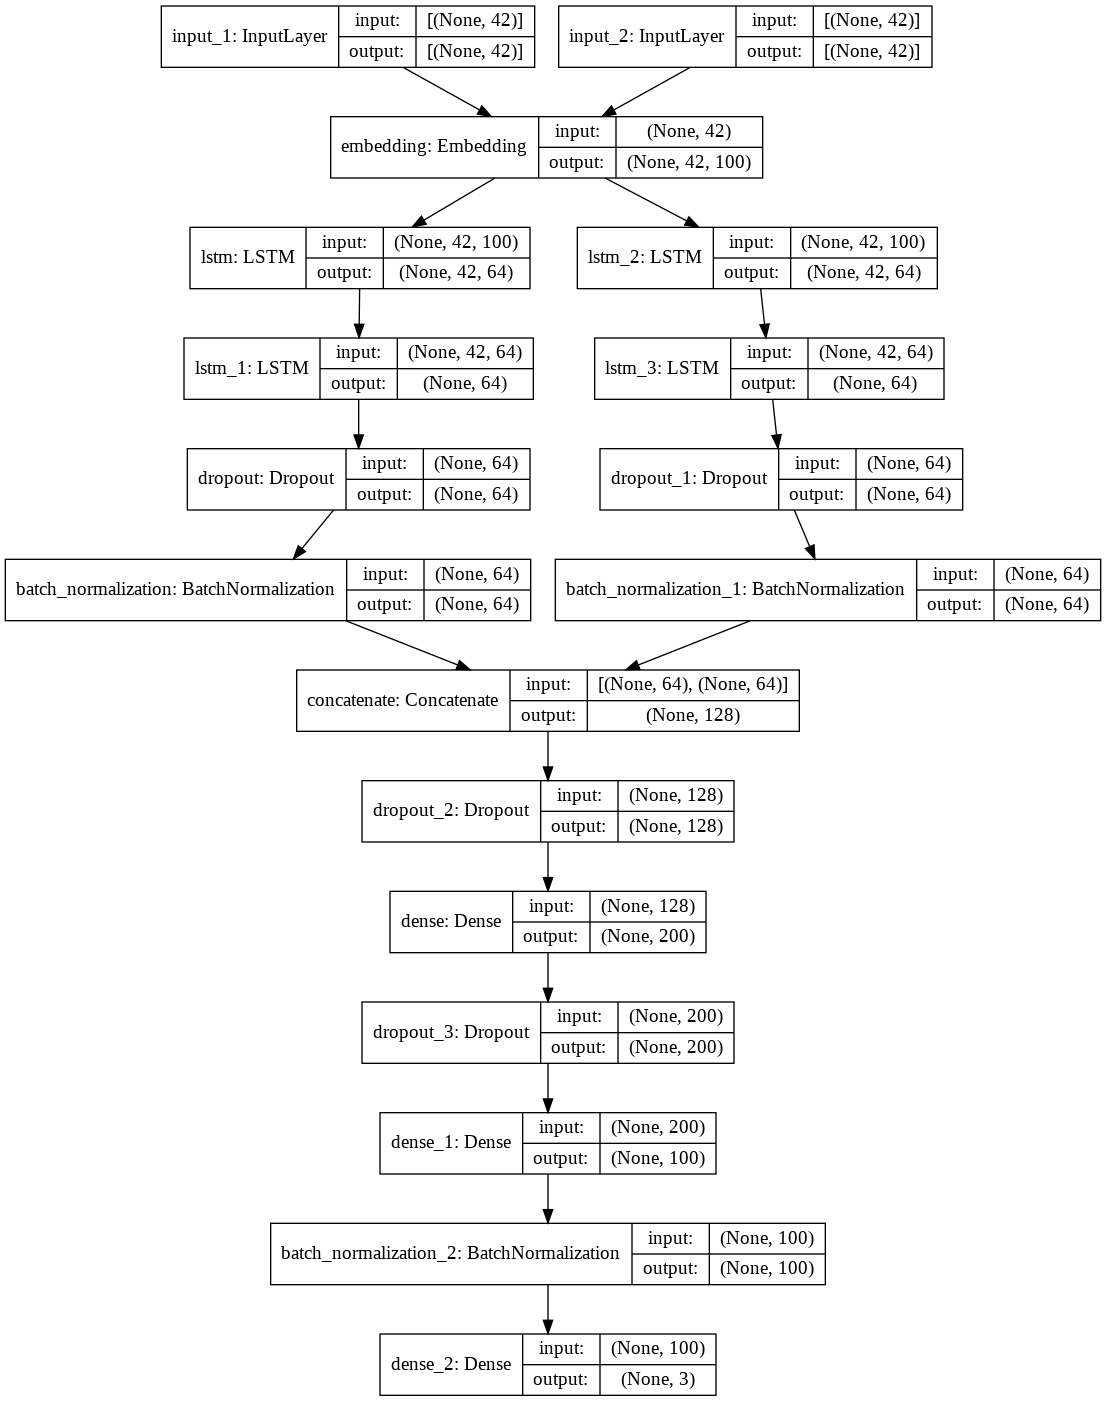

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
BATCH_SIZE = 512

In [ ]:

# Save the best model during validation and bail out of training early if we're not improving
callbacks = [EarlyStopping(patience=PATIENCE), ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)]
model.fit([training[0], training[1]], training[2], batch_size =BATCH_SIZE, epochs =10, validation_data=([validation[0], validation[1]], validation[2]), callbacks=callbacks)

# model.fit([training[0], training[1]], training[2], batch_size =BATCH_SIZE, epochs =10, validation_data=([validation[0], validation[1]], validation[2]))

Epoch 1/10
49/49 [==============================] - 93s 1s/step - loss: 1.3414 - accuracy: 0.3771 - val_loss: 1.0857 - val_accuracy: 0.4078
Epoch 2/10
49/49 [==============================] - 48s 976ms/step - loss: 1.0710 - accuracy: 0.4539 - val_loss: 1.0768 - val_accuracy: 0.4795
Epoch 3/10
49/49 [==============================] - 48s 973ms/step - loss: 1.0125 - accuracy: 0.4944 - val_loss: 1.0553 - val_accuracy: 0.4934
Epoch 4/10
49/49 [==============================] - 48s 983ms/step - loss: 0.9830 - accuracy: 0.5226 - val_loss: 1.0306 - val_accuracy: 0.5215
Epoch 5/10
49/49 [==============================] - 48s 980ms/step - loss: 0.9576 - accuracy: 0.5416 - val_loss: 1.0148 - val_accuracy: 0.5229
Epoch 6/10
49/49 [==============================] - 57s 1s/step - loss: 0.9436 - accuracy: 0.5459 - val_loss: 0.9815 - val_accuracy: 0.5536
Epoch 7/10
49/49 [==============================] - 48s 973ms/step - loss: 0.9262 - accuracy: 0.5592 - val_loss: 0.9603 - val_accuracy: 0.5609
Epoch

In [ ]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
import nltk
nltk.download('treebank')
nltk.download('brown')
nltk.download('conll2000')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


True

In [ ]:
nltk.download('universal_tagset')

In [ ]:
# load POS tagged corpora from NLTK
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus
# tagged_setences = 

In [ ]:
print(tagged_sentences)

In [ ]:
nltk.download('averaged_perceptron_tagger')
  

In [ ]:
nltk.download('punkt')

In [ ]:
# print(type(training[0]))
print(len(training[1]))

In [ ]:
type(training[1][1])


In [ ]:
X = [] # store input sequence
Y = [] # store output sequence

#I have taken 25000 samples as colab was crashing with more data
tokens = [nltk.sent_tokenize(x) for x in str(training[1][:25000]).split(" ")]



In [ ]:
Y.append( [ nltk.pos_tag(sentence) for sentence in tokens ] )

In [ ]:
tokens

In [ ]:
Y[0]

In [ ]:

I = [] # store input sequence
O = [] # store output sequence

for sentence in Y[0]:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    I.append(X_sentence)
    O.append(Y_sentence)

In [ ]:
# encode X

word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(I)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(I)  # use the tokeniser to encode input sequence

In [ ]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(O)
Y_encoded = tag_tokenizer.texts_to_sequences(O)

In [ ]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

In [ ]:
#padding

MAX_SEQ_LENGTH = 200  

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [ ]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

In [ ]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [ ]:
TEST_SIZE = 0.15


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X[:100], Y[:100], test_size=TEST_SIZE, random_state=4)

In [ ]:
VOCABULARY_SIZE = 20000
EMBEDDING_SIZE = 200
MAX_SEQ_LENGTH = 200

In [ ]:
X_train.shape

(85, 200)

In [ ]:
x = model.layers[-4]
x.output

<KerasTensor: shape=(None, 200) dtype=float32 (created by layer 'dropout_3')>

In [ ]:
NUM_CLASSES = Y.shape[2]
from tensorflow.keras.optimizers import Adam
x = model.layers[-4]
# create architecture

# model_p = Sequential([keras.Input(shape=(200,)), x])
model_p = Sequential()
model_p.add(model.layers[-4])
# model_p.add(Input(shape=(200,),dtype='float64') )
# create embedding layer
model_p.add(Embedding(input_dim     =  VOCABULARY_SIZE,         
                        output_dim    =  EMBEDDING_SIZE,          
                        input_length  =  200,          
                        trainable     =  False                   
))

# add an RNN layer which contains 64 RNN cells
model_p.add(SimpleRNN(2, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
model_p.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
# probe_layer = Dense(NUM_CLASSES, activation='softmax')(x)
x.trainable = False
# inputs = tf.keras.Input(shape=(61371,))
# model_p = Model(inputs=inputs, outputs=probe_layer)
model_p.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model_p.build(input_shape=(None, 200))
model_p.summary()
#probed layer should have compatiable dimension with the embedding layer/ probe layer


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 200)          4000000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 200, 2)            406       
_________________________________________________________________
time_distributed (TimeDistri (None, 200, 35)           105       
Total params: 4,000,511
Trainable params: 511
Non-trainable params: 4,000,000
_________________________________________________________________


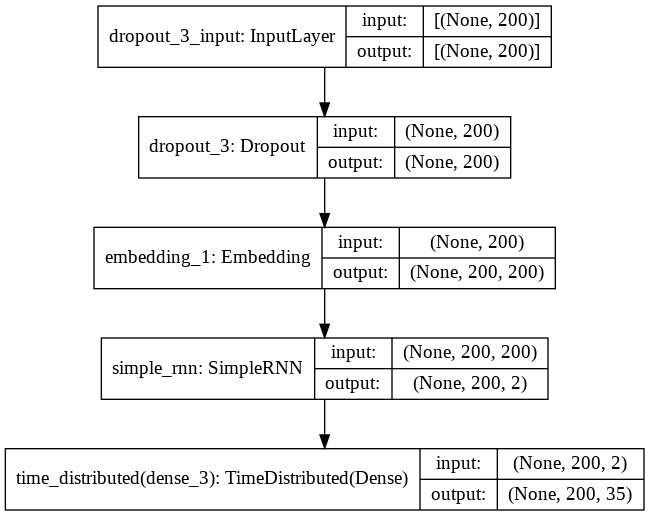

In [ ]:
plot_model(model_p, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model_p.fit(X_train, Y_train, batch_size=None, epochs = 5, validation_data=(X_test, Y_test))

In [ ]:
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()